In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 한글 설치

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (43.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and di

# KNN 모델

In [5]:
# 필요한 라이브러리 설치
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [3]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# 데이터 베이스 파일 불러오기
filename = '/content/drive/MyDrive/파이썬 머신러닝 기말/mlb-player-stats-Batters.csv'
df0 = pd.read_csv(filename)

In [8]:
df0.head()

,Player,Team,Pos,Age,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,SH,SF,HBP,AVG,OBP,SLG,OPS
0,Whit Merrifield,KC,2B,32,162,664,97,184,42,3,10,74,40,4,40,103,0,12,4,0.277,0.317,0.395,0.712
1,Marcus Semien,TOR,SS,31,162,652,115,173,39,2,45,102,15,1,66,146,0,3,3,0.265,0.334,0.538,0.872
2,Tommy Edman,STL,2B,26,159,641,91,168,41,3,11,56,30,5,38,95,2,4,6,0.262,0.308,0.387,0.695
3,Bo Bichette,TOR,SS,23,159,640,121,191,30,1,29,102,25,1,40,137,0,4,6,0.298,0.343,0.484,0.827
4,Isiah Kiner-Falefa,TEX,SS,26,158,635,74,172,25,3,8,53,20,5,28,90,1,2,11,0.271,0.312,0.357,0.669


In [9]:
# 비어있는 데이터 삭제
df0.isnull().sum()
df1 = df0.dropna()

In [12]:
# 사용할 포지션 데이터 제외한 데이터 삭제
idx_number_1 = df1[(df1['Pos'] != "SS") & (df1['Pos'] != "1B")].index
df2 = df1.drop(idx_number_1)

idx_number_2 = df2[(df2['G'] <= 30)].index
df3 = df2.drop(idx_number_2)

df3.Pos.value_counts()
df3.head()

,Player,Team,Pos,Age,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,SH,SF,HBP,AVG,OBP,SLG,OPS
1,Marcus Semien,TOR,SS,31,162,652,115,173,39,2,45,102,15,1,66,146,0,3,3,0.265,0.334,0.538,0.872
3,Bo Bichette,TOR,SS,23,159,640,121,191,30,1,29,102,25,1,40,137,0,4,6,0.298,0.343,0.484,0.827
4,Isiah Kiner-Falefa,TEX,SS,26,158,635,74,172,25,3,8,53,20,5,28,90,1,2,11,0.271,0.312,0.357,0.669
10,J.P. Crawford,SEA,SS,26,160,619,89,169,37,0,9,54,3,6,58,114,1,4,5,0.273,0.338,0.376,0.714
11,Vladimir Guerrero,TOR,1B,22,161,604,123,188,29,1,48,111,4,1,86,110,0,2,6,0.311,0.401,0.601,1.002


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


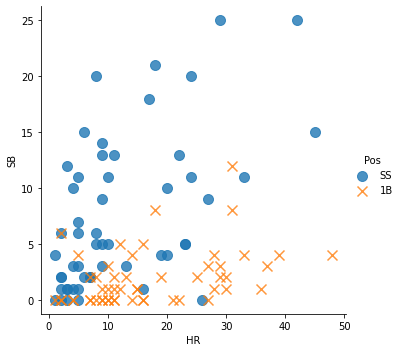

In [13]:
# HR 개수, SB 수로 데이터 Plot
sns.lmplot('HR', 'SB', data=df3, fit_reg=False,  # x 축, y 축, 데이터, 라인 없음
           scatter_kws={"s": 100}, # 좌표 상의 점의 크기
           markers=["o", "x"], # 그래프에 표기되는 point markers 모양 설정
           hue="Pos") # 예측값

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


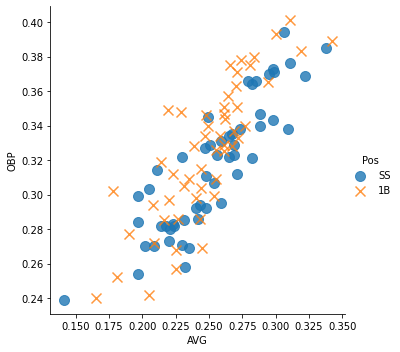

In [14]:
# AVG, OBP로 데이터를 Plot
sns.lmplot('AVG', 'OBP', data=df3, fit_reg=False,  # x 축, y 축, 데이터, 라인 없음
           scatter_kws={"s": 100}, # 좌표 상의 점의 크기
           markers=["o", "x"], # 그래프에 표기되는 point markers 모양 설정
           hue="Pos") # 예측값

In [17]:
# 사용하지 않을 데이터 삭제
df3.drop(["Team", "Age", "G", "R", "AB", "H", "2B", "3B", "RBI", "CS", "BB", "SO", "SH", "HBP"], axis = 1, inplace = True)
df3.head()

,Player,Pos,HR,SB,SF,AVG,OBP,SLG,OPS
1,Marcus Semien,SS,45,15,3,0.265,0.334,0.538,0.872
3,Bo Bichette,SS,29,25,4,0.298,0.343,0.484,0.827
4,Isiah Kiner-Falefa,SS,8,20,2,0.271,0.312,0.357,0.669
10,J.P. Crawford,SS,9,3,4,0.273,0.338,0.376,0.714
11,Vladimir Guerrero,1B,48,4,2,0.311,0.401,0.601,1.002


In [15]:
# 정규화
def min_max_normalized(list):
    normalized = []
    
    for x in list:
        normalized_x = (x - min(list)) / (max(list) - min(list))
        normalized.append(normalized_x)

    return normalized

def z_score_normalized(list):
    normalized = []
    
    for x in list:
        normalized_x = (x - np.mean(list)) / np.std(list)
        normalized.append(normalized_x)

    return normalized

In [18]:
print(df3.columns)
for i in df3.columns:
    if (i == 'Player'):
        continue
    elif (i == 'Pos'):
        continue
    df3[i] = z_score_normalized(df3[i])
    #print(df3[i])

df3.head()

Index(['Player', 'Pos', 'HR', 'SB', 'SF', 'AVG', 'OBP', 'SLG', 'OPS'], dtype='object')


,Player,Pos,HR,SB,SF,AVG,OBP,SLG,OPS
1,Marcus Semien,SS,2.758128,1.784563,0.174428,0.399407,0.343331,1.429026,1.150822
3,Bo Bichette,SS,1.313475,3.521602,0.585302,1.307220,0.574154,0.752958,0.744740
4,Isiah Kiner-Falefa,SS,-0.582631,2.653083,-0.236447,0.564464,-0.220903,-0.837053,-0.681061
10,J.P. Crawford,SS,-0.492340,-0.299885,0.585302,0.619483,0.445919,-0.599177,-0.274978
11,Vladimir Guerrero,1B,3.029000,-0.126181,-0.236447,1.664844,2.061678,2.217771,2.323950


In [31]:
train, test = train_test_split(df3, test_size=0.2) # 다듬어진 데이터에서 20%를 테스트 데이터로 분류

print(train.shape[0])# 학습 데이터의 갯수 확인
print(test.shape[0])# 테스트 데이터의 갯수 확인

84
22


In [32]:
max_k_range = train.shape[0] // 2 # find best k, range from 3 to half of the number of data
k_list = [] # k_list 선언 및 초기화
for i in range(3, max_k_range, 2): # 3 ~ max_k_range 만큼 2씩 더한 값을 i에 대입하며 반복
    k_list.append(i) # i 값을 k_list에 추가

print(k_list)

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41]


In [33]:
# HR, SB, OBP, SLG, OPS 데이터를 통해 train
cross_validation_scores = [] # cross_validation_scores 선언 및 초기화
x_train = train[['HR', 'SB',  'OBP', 'SLG', 'OPS']] 
y_train = train[['Pos']] 

for k in k_list:   # 10-fold cross validation
    knn = KNeighborsClassifier(n_neighbors=k) # neighbor를 k개 같는 KNeighborClssifier 선언
    scores = cross_val_score(knn, x_train, y_train.values.ravel(),  # cross validation score 계산 (모델, 입력, 타겟), ravel 다차원배열을 1차원으로
                             cv=10, scoring='accuracy') # 10 fold로 설정, score는 accuracy로 계산
    cross_validation_scores.append(scores.mean()) # 전체 score의 평균값을 cross_validation_scroe에 추가

cross_validation_scores

[0.7722222222222223,
 0.725,
 0.7041666666666666,
 0.6805555555555556,
 0.7166666666666666,
 0.7166666666666667,
 0.7041666666666667,
 0.7041666666666667,
 0.7152777777777778,
 0.7291666666666666,
 0.7180555555555556,
 0.6944444444444444,
 0.6944444444444444,
 0.6944444444444444,
 0.7166666666666667,
 0.7166666666666667,
 0.7166666666666667,
 0.6791666666666667,
 0.701388888888889,
 0.6555555555555556]

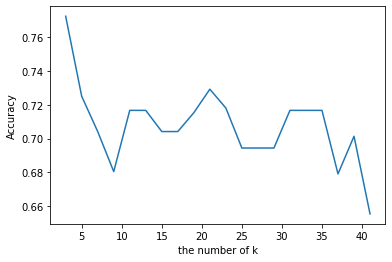

The best number of k : 3


In [34]:
# k에 따른 accuracy
plt.plot(k_list, cross_validation_scores) # visualize accuracy according to k
plt.xlabel('the number of k') # x축 제목 설정
plt.ylabel('Accuracy') # y축 제목 설정
plt.show() # 그래프 출력
cvs = cross_validation_scores # cvs에 cross_validation_scores 대입
k = k_list[cvs.index(max(cross_validation_scores))] # cross_validation_score가 가장 높은 값의 index를 찾아 k_list에서 최적의 k값을 반환하여 대입
print("The best number of k : " + str(k) ) # str(k): 정수형 k를 문자열(string)으로 변환

In [35]:
# 모델 테스트
knn = KNeighborsClassifier(n_neighbors=k) # neighbor의 개수를 k개 갖는 KNeighborClassifier 선언

x_train = train[['HR', 'SB',  'OBP', 'SLG', 'OPS']] 
y_train = train[['Pos']] 

knn.fit(x_train, y_train.values.ravel()) # setup knn using train data

x_test = test[['HR', 'SB',  'OBP', 'SLG', 'OPS']] # select data feature to be used for prediction
y_test = test[['Pos']] # select target value
pred = knn.predict(x_test) # test
print("accuracy : "+  # check accuracy
          str(accuracy_score(y_test.values.ravel(), pred)) ) # 실제 타겟 데이터와 예측 값을 통해 정확도(accuracy)를 계산하고 이를 문자열(string)으로 변환

comparison = pd.DataFrame({'prediction':pred, 'ground_truth':y_test.values.ravel()}) # 예측값과 정답(ground truth) 데이터를 pandas dataframe으로 선언
comparison.head(20) # comparison의 상위 10개 데이터를 반환

accuracy : 0.8181818181818182


,prediction,ground_truth
0,SS,SS
1,SS,SS
2,SS,1B
3,SS,SS
4,SS,SS
5,1B,1B
6,SS,SS
7,SS,SS
8,1B,1B
9,SS,SS


# SVM

In [36]:
# SVM에 사용할 라이브러리 호출
from sklearn.model_selection import GridSearchCV  
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split # sklearn의 train_test_split을 사용하면 라인 한줄로 손쉽게 데이터를 나눌 수 있음
from sklearn.svm import SVC 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [37]:
# 데이터 파일 로드
filename = '/content/drive/MyDrive/파이썬 머신러닝 기말/mlb-player-stats-Batters.csv'
df00 = pd.read_csv(filename)
df00.head()

,Player,Team,Pos,Age,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,SH,SF,HBP,AVG,OBP,SLG,OPS
0,Whit Merrifield,KC,2B,32,162,664,97,184,42,3,10,74,40,4,40,103,0,12,4,0.277,0.317,0.395,0.712
1,Marcus Semien,TOR,SS,31,162,652,115,173,39,2,45,102,15,1,66,146,0,3,3,0.265,0.334,0.538,0.872
2,Tommy Edman,STL,2B,26,159,641,91,168,41,3,11,56,30,5,38,95,2,4,6,0.262,0.308,0.387,0.695
3,Bo Bichette,TOR,SS,23,159,640,121,191,30,1,29,102,25,1,40,137,0,4,6,0.298,0.343,0.484,0.827
4,Isiah Kiner-Falefa,TEX,SS,26,158,635,74,172,25,3,8,53,20,5,28,90,1,2,11,0.271,0.312,0.357,0.669


In [38]:
# KNN에서 했던것처럼 데이터 전처리
df00.isnull().sum()
df01 = df00.dropna()

idx_number_1 = df01[(df1['Pos'] != "SS") & (df01['Pos'] != "1B")].index
df02 = df01.drop(idx_number_1)

idx_number_2 = df02[(df02['G'] <= 30)].index
df03 = df02.drop(idx_number_2)

df03.Pos.value_counts()
df03.head()

,Player,Team,Pos,Age,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,SH,SF,HBP,AVG,OBP,SLG,OPS
1,Marcus Semien,TOR,SS,31,162,652,115,173,39,2,45,102,15,1,66,146,0,3,3,0.265,0.334,0.538,0.872
3,Bo Bichette,TOR,SS,23,159,640,121,191,30,1,29,102,25,1,40,137,0,4,6,0.298,0.343,0.484,0.827
4,Isiah Kiner-Falefa,TEX,SS,26,158,635,74,172,25,3,8,53,20,5,28,90,1,2,11,0.271,0.312,0.357,0.669
10,J.P. Crawford,SEA,SS,26,160,619,89,169,37,0,9,54,3,6,58,114,1,4,5,0.273,0.338,0.376,0.714
11,Vladimir Guerrero,TOR,1B,22,161,604,123,188,29,1,48,111,4,1,86,110,0,2,6,0.311,0.401,0.601,1.002


In [39]:
# 사용하지 않을 데이터 삭제
df03.drop(["Team", "Age", "G", "R", "AB", "H", "2B", "3B", "RBI", "CS", "BB", "SO", "SH", "HBP"], axis = 1, inplace = True)
df03.head()

,Player,Pos,HR,SB,SF,AVG,OBP,SLG,OPS
1,Marcus Semien,SS,45,15,3,0.265,0.334,0.538,0.872
3,Bo Bichette,SS,29,25,4,0.298,0.343,0.484,0.827
4,Isiah Kiner-Falefa,SS,8,20,2,0.271,0.312,0.357,0.669
10,J.P. Crawford,SS,9,3,4,0.273,0.338,0.376,0.714
11,Vladimir Guerrero,1B,48,4,2,0.311,0.401,0.601,1.002


In [40]:
# 정규화
def min_max_normalized(list):
    normalized = []
    
    for x in list:
        normalized_x = (x - min(list)) / (max(list) - min(list))
        normalized.append(normalized_x)

    return normalized

def z_score_normalized(list):
    normalized = []
    
    for x in list:
        normalized_x = (x - np.mean(list)) / np.std(list)
        normalized.append(normalized_x)

    return normalized

In [41]:
print(df03.columns)
for i in df03.columns:
    if (i == 'Player'):
        continue
    elif (i == 'Pos'):
        continue
    df03[i] = min_max_normalized(df03[i])
    #print(df3[i])

df03.head()

Index(['Player', 'Pos', 'HR', 'SB', 'SF', 'AVG', 'OBP', 'SLG', 'OPS'], dtype='object')


,Player,Pos,HR,SB,SF,AVG,OBP,SLG,OPS
1,Marcus Semien,SS,0.936170,0.60,0.250000,0.616915,0.586420,0.778761,0.729730
3,Bo Bichette,SS,0.595745,1.00,0.333333,0.781095,0.641975,0.619469,0.636175
4,Isiah Kiner-Falefa,SS,0.148936,0.80,0.166667,0.646766,0.450617,0.244838,0.307692
10,J.P. Crawford,SS,0.170213,0.12,0.333333,0.656716,0.611111,0.300885,0.401247
11,Vladimir Guerrero,1B,1.000000,0.16,0.166667,0.845771,1.000000,0.964602,1.000000


In [42]:
# train에 사용할 attribute (많은 테스트를 해보기 위해 변수화)
test1 = 'SB'
test2 = 'HR'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


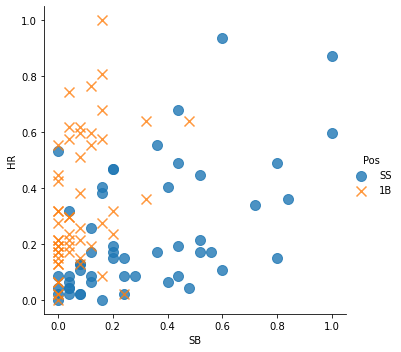

In [43]:
sns.lmplot(test1, test2, data=df03, fit_reg=False,  # x 축, y 축, 데이터, 라인 없음
           scatter_kws={"s": 100}, # 좌표 상의 점의 크기
           markers=["o", "x"], # 그래프에 표기되는 point markers 모양 설정
           hue="Pos") # 예측값

In [45]:
train, test = train_test_split(df03, test_size=0.2)

In [46]:
def svc_param_selection(X, y, nfolds):  # 사이킷런에서 제공하는 GridSearchCV를 사용해 최적의 파라미터를 구함
  svm_parameters = [{'kernel': ['rbf'], # svm_parameters 선언
                     'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
                     'C': [0.01, 0.1, 1, 10, 100, 1000]}]
  clf = GridSearchCV(SVC(), svm_parameters, cv=nfolds)  # GridSearch에 들어갈 model(SVC)과 파라미터(svm_parameters), cv_fold(10) 설정하여 선언
  clf.fit(X, y)  #  GridSearch를 통해 입력데이터와 정답 데이터에 맞는 parameter를 찾아 학습
  print(clf.best_params_) # 최적의 파라미터를 출력
  return clf # 최적의 파라미터로 학습된 모델을 반환

# test1과 test2 attribute를 학습 데이터로 사용 
X_train = train[[test1, test2]]
#print(X_train)

# 야구선수 포지션을 예측값으로 선정
y_train = train[['Pos']]
#print(y_train)

# 최적의 파라미터로 학습된 모델을 clf로 저장
clf = svc_param_selection(X_train, y_train.values.ravel(), 10)

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}


In [47]:
# 시각화할 비용 후보들을 저장
C_canditates = []  # C_candidates 선언 및 초기화
C_canditates.append(clf.best_params_['C'] * 0.01) # C_candidates에 clf best 파라미터 C에 0.01을 곱한 값을 추가
C_canditates.append(clf.best_params_['C'])  # C_candidates에 clf best 파라미터 C를 추가
C_canditates.append(clf.best_params_['C'] * 100) # C_candidates에 clf best 파라미터 C에 100을 곱한 값을 추가
#print(C_canditates)

# 시각화할 감마 후보들을 저장
gamma_candidates = [] # gamma_candidates 선언 및 초기화
gamma_candidates.append(clf.best_params_['gamma'] * 0.01) # gamma_candidates에 clf best 파라미터 gamma에 0.01을 곱한 값을 추가
gamma_candidates.append(clf.best_params_['gamma']) # gamma_candidates에 clf best 파라미터 gamma를 추가
gamma_candidates.append(clf.best_params_['gamma'] * 100) # gamma_candidates에 clf best 파라미터 gamma에 100을 곱한 값을 추가
#print(gamma_candidates)

# test1과 test2 attribute로 학습
X = train[[test1, test2]] # train에서 SLG와 SB에 해당하는 데이터를 X에 대입
print(X)
# 야구선수 포지션을 학습 모델의 분류값으로 사용
Y = train['Pos'].tolist() # train에서 Pos데이터에 해당하는 데이터를 list로 변환하여 Y에 대입
#print(Y)
# 시각화를 위해 1B와 SS를 숫자로 표현

position = []  # position 선언 및 초기화
for gt in Y: # Y 리스트 안에 있는 값을 하나씩 gt에 대입하며 반복
  if gt == '1B': # gt가 C이면 0을 position에 추가
    position.append(0)
  else: # gt가 C가 아니면 1을 position에 추가
    position.append(1) 

classifiers = [] # classifiers 선언 및 초기화

       SB        HR
53   0.20  0.468085
447  0.16  0.085106
39   0.52  0.212766
98   0.08  0.617021
470  0.00  0.000000
..    ...       ...
374  0.08  0.148936
352  0.44  0.085106
299  0.12  0.085106
79   0.48  0.042553
300  0.08  0.021277

[84 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packa

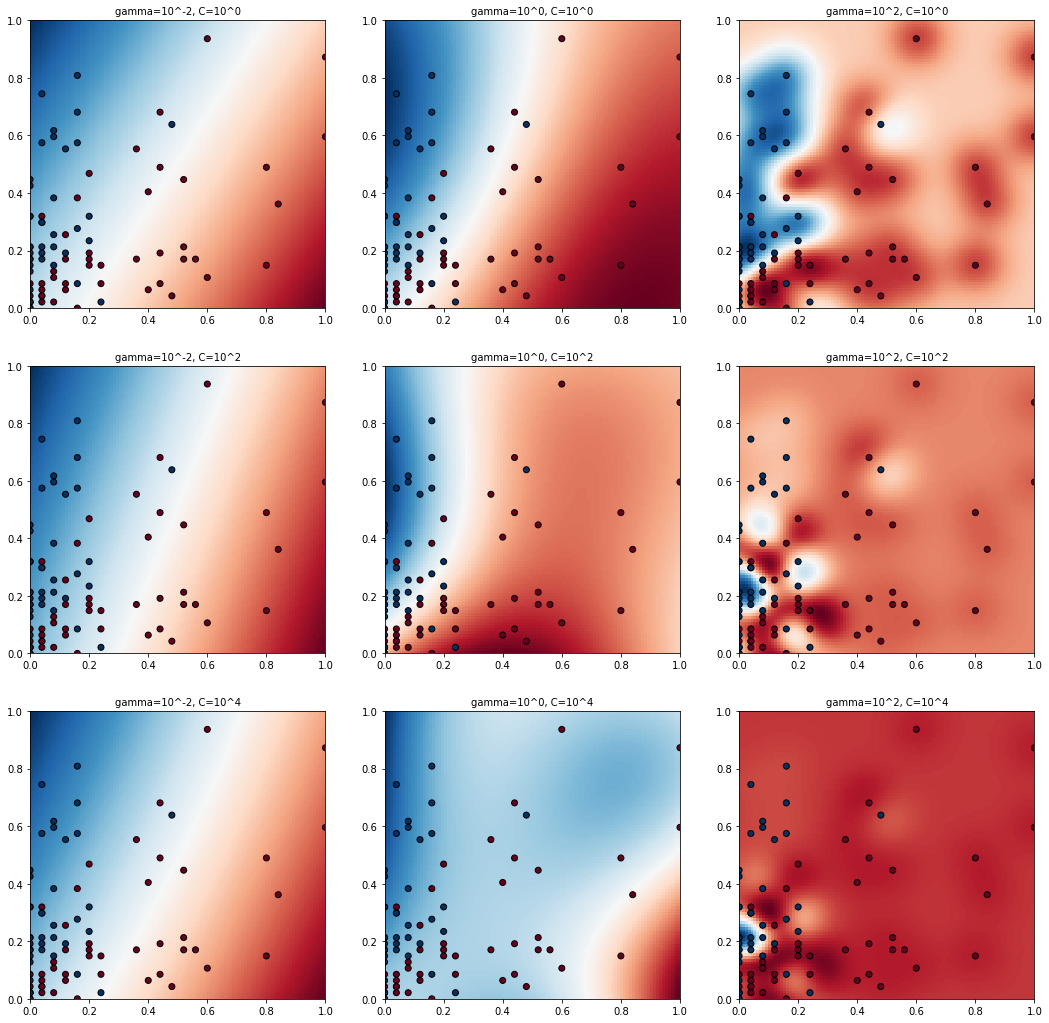

In [48]:
# 파라미터 후보들을 조합해서 학습된 모델들을 저장
for C in C_canditates: # C_candidates 값을 하나씩 C에 대입하면서 반복
  for gamma in gamma_candidates: # gamma_candidates 값을 하나씩 gamma에 대입하면서 반복
      clf = SVC(C=C, gamma=gamma) # C와 gamma를 파라미터로 지정한 SVC 선언
      clf.fit(X, Y) # 입력 데이터(X), 정답 데이터(Y) 데이터로 학습
      classifiers.append((C, gamma, clf)) # 파라미터 C, gamma, 학습된 모델을 classifiers에 추가
#print(classifiers)
# 각 모델을 시각화
plt.figure(figsize=(18, 18)) # 18, 18 크기의 figure 생성
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100)) # 0~4 사이의 100개의 수열을 x축 기준, y축 기준으로 생성

for (k, (C, gamma, clf)) in enumerate(classifiers):
  Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) # decision function 생성 [xx+yy]
  Z = Z.reshape(xx.shape) # decision function reshape [xx,yy]

  plt.subplot(len(C_canditates), len(gamma_candidates), k + 1) # [C_candidates, gamma_candidates] 크기의 k+1 번째 subplot 생성
  plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size='medium') # 그래프 제목 설정, size는 medium

  plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu) # [xx,yy,-Z]의 pcolormesh 생성, cmap(colormap)은 red, blue로 설정
  plt.scatter(X[test1], X[test2], c=position, cmap=plt.cm.RdBu_r, edgecolors='k') # scatter 그래프 생성 (X['SLG'], X['SB']), c(color)는 position(0,1)로 설정, cmap(colormap)은 red, blue로 설정, edgecolor는 k(검정)

In [49]:
X_test = test[[test1, test2]] # test에서 test1과 test2에 해당하는 데이터를 X_test에 대입
y_test = test[['Pos']] # test에서 Pos에 해당하는 데이터를 y_test에 대입

# 최적의 파라미터로 학습된 모델로 테스트를 진행
y_true, y_pred = y_test, clf.predict(X_test) # y_test는 y_true에 대입하고, X_pred에는 clf에 X_test를 입력으로 넣어서 예측된 값을 대입

print(classification_report(y_true, y_pred)) # classification_report 함수를 통해 정답과 예측된 값 결과 비교 리포트 출력
print() # 한 줄 띄우기
print("accuracy : "+ str(accuracy_score(y_true, y_pred)) ) # accuracy_score 함수를 통해 정확도 수치 출력

              precision    recall  f1-score   support

          1B       0.86      0.86      0.86        14
          SS       0.75      0.75      0.75         8

    accuracy                           0.82        22
   macro avg       0.80      0.80      0.80        22
weighted avg       0.82      0.82      0.82        22


accuracy : 0.8181818181818182


In [50]:
comparison = pd.DataFrame({'prediction': y_pred, 
                           'ground_truth': y_true.values.ravel()}) # 예측값과 정답을 padnas dataframe으로 만들어 출력
comparison

,prediction,ground_truth
0,1B,SS
1,SS,SS
2,SS,SS
3,SS,SS
4,1B,1B
5,1B,1B
6,1B,1B
7,SS,SS
8,SS,SS
9,1B,1B
